Trail dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import numpy as np
import pickle
import pandas as pd


In [3]:
import pandas as pd
import numpy as np

def add_lag(x, y, lag):
    """
    Align a single predictor sequence x with response sequence y such that
      x_lag[k] corresponds to y_lag[k] = y[k + lag]

    Common use case: use past values of x to predict the current value of y:
       When lag > 0:
           x_lag = x.iloc[0 : len(x) - lag]
           y_lag = y.iloc[lag : len(y)]
       When lag = 0:
           both are returned as-is.

    Parameters:
    - x: pd.Series or np.ndarray, the predictor to be lagged (one-dimensional).
    - y: pd.Series or np.ndarray, the corresponding response variable (one-dimensional).
    - lag: int, number of lag steps (non-negative integer).

    Returns:
    - x_lagged, y_lagged:
        Same type as the inputs (if x and y are pd.Series, returns pd.Series;
        if they are np.ndarray, returns np.ndarray);
        Each has length max_length = len(x) - lag = len(y) - lag.
    """

    if lag < 0:
        raise ValueError(f"lag must be a non-negative integer; got {lag}")

    # If both inputs are pandas.Series
    if isinstance(x, pd.Series) and isinstance(y, pd.Series):
        if lag == 0:
            # Return copies to avoid unintended external modifications
            return x.reset_index(drop=True).copy(), y.reset_index(drop=True).copy()

        # Ensure length is sufficient
        if lag >= len(x) or lag >= len(y):
            raise ValueError(f"lag={lag} is too large; exceeds series length (len={len(x)})")

        # Create lagged versions: x[0:len-lag] aligns with y[lag:len]
        x_lagged = x.iloc[0 : len(x) - lag].reset_index(drop=True)
        y_lagged = y.iloc[lag : len(y)].reset_index(drop=True)
        return x_lagged, y_lagged

    # If both inputs are numpy.ndarray
    elif isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        if lag == 0:
            return x.copy(), y.copy()

        if lag >= x.shape[0] or lag >= y.shape[0]:
            raise ValueError(f"lag={lag} is too large; exceeds array length (len={x.shape[0]})")

        x_lagged = x[0 : x.shape[0] - lag].copy()
        y_lagged = y[lag : y.shape[0]].copy()
        return x_lagged, y_lagged

    else:
        raise TypeError("add_lag: x and y must both be pandas.Series or both be numpy.ndarray.")


In [4]:
x = tf.keras.Input(shape=(None,), dtype=tf.float32, name='input_cnn')
y = tf.keras.Input(shape=(None,), dtype=tf.float32, name='train_output_cnn')

Simple Network


In [5]:
# ----------------------------------------------------
# train_with_refine.py
# ----------------------------------------------------
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

# Force TF1.x graph execution mode (disable Eager), otherwise using placeholders
# will cause “Cannot use KerasTensor with tf.function” errors.
tf.compat.v1.disable_eager_execution()

# ----------------------------------------------------
# Hyperparameter settings
# ----------------------------------------------------
lag_range     = 20
lag_epoch_num = 20
# input_size: (time_steps, one_hot_dim, 1, 1); here one_hot_dim = 31
input_size    = (20, 3, 1, 1)

n_classes = 1   # If doing regression, set to 1; if classification, set to the number of classes
learning_rate = 1e-3

# ----------------------------------------------------
# 1) Define TF1-style placeholders
# ----------------------------------------------------
# Assume each window we feed into refine is a one-hot vector of shape (31,),
# which inside refine will be reshaped to (20, 31, 1, 1)
x = tf.compat.v1.placeholder(tf.float32, shape=[None, 3], name='input_placeholder')
y = tf.compat.v1.placeholder(tf.float32, shape=[None],    name='label_placeholder')

# ----------------------------------------------------
# 2) Define a simple feed-forward regression model in the computation graph.
#    For demonstration, this is just one fully connected layer. You can replace
#    it with your original convolutional model; this example is simplified.
# ----------------------------------------------------
def build_simple_regression_model(input_tensor):
    """
    Input:  input_tensor, shape = [batch, 3]
    Output: prediction,   shape = [batch]
    """
    with tf.compat.v1.variable_scope("simple_fc", reuse=tf.compat.v1.AUTO_REUSE):
        # Map from 31 → 64 → 1
        W1 = tf.compat.v1.get_variable("W1", shape=[3, 64],
                                       initializer=tf.random_normal_initializer())
        b1 = tf.compat.v1.get_variable("b1", shape=[64],
                                       initializer=tf.random_normal_initializer())
        h1 = tf.nn.relu(tf.matmul(input_tensor, W1) + b1)

        W2 = tf.compat.v1.get_variable("W2", shape=[64, 1],
                                       initializer=tf.random_normal_initializer())
        b2 = tf.compat.v1.get_variable("b2", shape=[1],
                                       initializer=tf.random_normal_initializer())
        out = tf.matmul(h1, W2) + b2  # shape [batch, 1]
        out = tf.squeeze(out, axis=1) # → [batch]
        return out

# Build prediction tensor in the graph
prediction = build_simple_regression_model(x)

# Loss: Mean Squared Error (MSE)
cost = tf.reduce_mean(tf.square(prediction - y))

# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cost)

# ----------------------------------------------------
# 3) Define the refine_input_with_lag_multi function here
#    (or import it from elsewhere). Below is a minimal version
#    that ensures x, y, prediction, cost, optimizer are the graph nodes above.
# ----------------------------------------------------

def refine_input_with_lag_multi(x_train: pd.DataFrame,
                                y_train: pd.Series,
                                x_test: pd.DataFrame,
                                y_test: pd.Series):
    """
    Search for the best lag independently for each column in x_train.
      - x_train: DataFrame, shape = [num_samples, num_features]
      - y_train: Series,   shape = [num_samples]
      - x_test, y_test are the same structure.
    Returns:
      best_lags: List[int], the best lag for each column
      x_train_lagged, y_train_lagged, x_test_lagged, y_test_lagged:
         Aligned versions ready for the next training step.
    """

    n_features = x_train.shape[1]
    feature_names = list(x_train.columns)
    best_lags = [0] * n_features

    for j, col in enumerate(feature_names):
        print(f"==> Searching best lag for feature [{j+1}/{n_features}] '{col}' ...")
        all_lag_losses = []

        for i in range(lag_range):
            # ---------------------------
            # 1) Construct the training subset for lag = i (only lag column j)
            # ---------------------------
            x_tr_j = x_train.copy().reset_index(drop=True)
            y_tr_j = y_train.copy().reset_index(drop=True)

            if i > 0:
                # Apply lag to column j
                x_col_lagged, y_lagged = add_lag(x_tr_j[col], y_tr_j, i)
                x_tr_j[col] = x_col_lagged
                # Truncate the first i rows of the other columns
                for k, other in enumerate(feature_names):
                    if k != j:
                        x_tr_j[other] = x_tr_j[other].iloc[i:].reset_index(drop=True)
                # Align y
                y_tr_j = y_lagged
                x_tr_j = x_tr_j.iloc[0: len(y_tr_j)].reset_index(drop=True)
            # If lag == 0, use original data directly

            # ---------------------------
            # 2) Quickly train for lag_epoch_num epochs and accumulate loss
            # ---------------------------
            with tf.compat.v1.Session() as sess:
                sess.run(tf.compat.v1.global_variables_initializer())

                for epoch in range(lag_epoch_num):
                    lag_loss = 0.0
                    num_segments = int(len(x_tr_j) / input_size[0])
                    for seg in range(num_segments):
                        # Extract the next window of length input_size[0]
                        window_values = x_tr_j[col].values[seg*input_size[0] : seg*input_size[0] + input_size[0]]
                        # Build one-hot input: shape = [batch_size=input_size[0], one_hot_dim=31]
                        # Here we treat batch_size as “one batch containing input_size[0] samples”,
                        # so the placeholder x=[None,31] input becomes shape (20,31)
                        x_in = np.zeros((input_size[0], input_size[1]), dtype=np.float32)
                        for idx, v in enumerate(window_values):
                            x_in[idx, int(v)] = 1.0
                        # Build y_in: shape = [input_size[0]]
                        y_in = y_tr_j.values[seg*input_size[0] : seg*input_size[0] + input_size[0]]

                        # Run optimization
                        _, c = sess.run([optimizer, cost], feed_dict={x: x_in, y: y_in})
                        lag_loss += float(c)

                    # (Optional) print loss per epoch:
                    # print(f"    col='{col}', lag={i}, epoch={epoch+1}/{lag_epoch_num}, loss={lag_loss:.4f}")

                all_lag_losses.append(lag_loss)

        best_i = int(np.argmin(all_lag_losses))
        best_lags[j] = best_i
        print(f"  >>> Best lag for feature '{col}' = {best_i}, corresponding loss = {all_lag_losses[best_i]:.4f}\n")

    # ---------------------------
    # 3) After determining the best lag for each column,
    #    align everything according to the maximum lag
    # ---------------------------
    max_lag = max(best_lags)

    # Align y_train and y_test first using max_lag
    y_train_lagged = y_train.copy().reset_index(drop=True)
    y_test_lagged  = y_test.copy().reset_index(drop=True)
    if max_lag > 0:
        _, y_train_lagged = add_lag(y_train_lagged, y_train_lagged, max_lag)
        _, y_test_lagged  = add_lag(y_test_lagged,  y_test_lagged,  max_lag)

    # Build aligned X_train_lagged and X_test_lagged
    X_tr_lagged = pd.DataFrame()
    X_te_lagged = pd.DataFrame()

    for j, col in enumerate(feature_names):
        lag_j = best_lags[j]
        col_train = x_train[col].copy().reset_index(drop=True)
        col_test  = x_test[col].copy().reset_index(drop=True)

        if lag_j > 0:
            col_tr_l, _ = add_lag(col_train, col_train, lag_j)
            col_te_l, _ = add_lag(col_test,  col_test,  lag_j)
        else:
            col_tr_l = col_train.copy()
            col_te_l = col_test.copy()

        # Truncate to the same length as y_train_lagged
        col_tr_l = col_tr_l.iloc[0: len(y_train_lagged)].reset_index(drop=True)
        col_te_l = col_te_l.iloc[0: len(y_test_lagged)].reset_index(drop=True)

        X_tr_lagged[col] = col_tr_l
        X_te_lagged[col] = col_te_l

    # Save best_lags
   # pickle.dump(best_lags, open("data/best_lags_per_feature.p", "wb"))

    return best_lags, X_tr_lagged, y_train_lagged, X_te_lagged, y_test_lagged

# ----------------------------------------------------
# 4) Demonstrate how to actually call refine_input_with_lag_multi
# ----------------------------------------------------
if __name__ == "__main__":
    # 4.1 Prepare the real X_train, y_train, X_test, y_test
    # Assume you have read in:
    #   X_train: DataFrame with shape = (1837, 3)
    #   y_train: Series    with shape = (1837,)
    #   X_test:  DataFrame with shape = (460, 3)
    #   y_test:  Series    with shape = (460,)

    # The following just simulates data; in practice, load your own data.
    X_train = pd.DataFrame(
        np.random.randint(0, 3, size=(1837, 3)),
        columns=[f"feat_{i}" for i in range(3)]
    )
    y_train = pd.Series(np.random.randn(1837))

    X_test = pd.DataFrame(
        np.random.randint(0, 3, size=(460, 3)),
        columns=[f"feat_{i}" for i in range(3)]
    )
    y_test = pd.Series(np.random.randn(460))

    # 4.2 Directly call the function
    best_lags, X_tr_lagged, y_tr_lagged, X_te_lagged, y_te_lagged = \
        refine_input_with_lag_multi(X_train, y_train, X_test, y_test)

    print("Final best lag for each column:", best_lags)
    print("Aligned training set shape:", X_tr_lagged.shape, y_tr_lagged.shape)
    print("Aligned testing set shape: ", X_te_lagged.shape, y_te_lagged.shape)

    # From here,  use X_tr_lagged, y_tr_lagged for your actual model training and evaluation.


==> Searching best lag for feature [1/3] 'feat_0' ...
  >>> Best lag for feature 'feat_0' = 18, corresponding loss = 93.8416

==> Searching best lag for feature [2/3] 'feat_1' ...
  >>> Best lag for feature 'feat_1' = 18, corresponding loss = 93.2147

==> Searching best lag for feature [3/3] 'feat_2' ...
  >>> Best lag for feature 'feat_2' = 18, corresponding loss = 93.8707

Final best lag for each column: [18, 18, 18]
Aligned training set shape: (1819, 3) (1819,)
Aligned testing set shape:  (442, 3) (442,)


In [6]:
# train_with_refine.py

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle


tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

# Hyper parameter
lag_range     = 20
lag_epoch_num = 20
time_steps    = 20
one_hot_dim   = 3
input_size    = (time_steps, one_hot_dim, 1, 1)

hm_epoch      = 10
learning_rate = 1e-3

# ----------------------------------------
x = tf.compat.v1.placeholder(tf.float32, shape=[None, 3], name='input_placeholder')
y = tf.compat.v1.placeholder(tf.float32, shape=[None],   name='label_placeholder')


def build_simple_regression_model(input_tensor):
    """
    Input:  input_tensor，shape = [batch, 3]
    Output: prediction，  shape = [batch]
    """
    with tf.compat.v1.variable_scope("simple_fc", reuse=tf.compat.v1.AUTO_REUSE):
        # first layer：3 → 64
        W1 = tf.compat.v1.get_variable(
            "W1",
            shape=[3, 64],
            initializer=tf.random_normal_initializer()
        )
        b1 = tf.compat.v1.get_variable(
            "b1",
            shape=[64],
            initializer=tf.random_normal_initializer()
        )
        h1 = tf.nn.relu(tf.matmul(input_tensor, W1) + b1)

        # Second layer：64 → 1
        W2 = tf.compat.v1.get_variable(
            "W2",
            shape=[64, 1],
            initializer=tf.random_normal_initializer()
        )
        b2 = tf.compat.v1.get_variable(
            "b2",
            shape=[1],
            initializer=tf.random_normal_initializer()
        )
        out = tf.matmul(h1, W2) + b2   # shape [batch, 1]
        out = tf.squeeze(out, axis=1)  # → [batch]
        return out

prediction = build_simple_regression_model(x)

# Loss: Mean Squared Error (MSE)
cost = tf.reduce_mean(tf.square(prediction - y))

# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cost)


def refine_input_with_lag_multi(x_train: pd.DataFrame,
                                y_train: pd.Series,
                                x_test: pd.DataFrame,
                                y_test: pd.Series):
    """
    find lag for each feature in x_train。
      - x_train: DataFrame, shape = [num_samples, num_features]
      - y_train: Series,   shape = [num_samples]
      - x_test, y_test: same structure。
    return：
      best_lags: List[int]，best lag for each feature,
      x_train_lagged, y_train_lagged, x_test_lagged, y_test_lagged:
    """
    n_features = x_train.shape[1]
    feature_names = list(x_train.columns)
    best_lags = [0] * n_features

    for j, col in enumerate(feature_names):
        print(f"==> Find lag for [{j+1}/{n_features}] '{col}' Find best lag …")
        all_lag_losses = []

        for i in range(lag_range):

            x_tr_j = x_train.copy().reset_index(drop=True)
            y_tr_j = y_train.copy().reset_index(drop=True)

            if i > 0:
                x_col_lagged, y_lagged = add_lag(x_tr_j[col], y_tr_j, i)
                x_tr_j[col] = x_col_lagged
                for k, other in enumerate(feature_names):
                    if k != j:
                        x_tr_j[other] = x_tr_j[other].iloc[i:].reset_index(drop=True)
                y_tr_j = y_lagged
                x_tr_j = x_tr_j.iloc[0: len(y_tr_j)].reset_index(drop=True)


            with tf.compat.v1.Session() as sess:
                sess.run(tf.compat.v1.global_variables_initializer())

                for epoch in range(lag_epoch_num):
                    lag_loss = 0.0
                    num_segments = int(len(x_tr_j) / input_size[0])
                    for seg in range(num_segments):
                        window_values = x_tr_j[col].values[
                            seg*input_size[0] : seg*input_size[0] + input_size[0]
                        ]

                        x_in = np.zeros((input_size[0], input_size[1]), dtype=np.float32)
                        for idx, v in enumerate(window_values):
                            x_in[idx, int(v)] = 1.0

                        y_in = y_tr_j.values[
                            seg*input_size[0] : seg*input_size[0] + input_size[0]
                        ]

                        _, c = sess.run([optimizer, cost], feed_dict={x: x_in, y: y_in})
                        lag_loss += float(c)

                all_lag_losses.append(lag_loss)

        best_i = int(np.argmin(all_lag_losses))
        best_lags[j] = best_i
        print(f"  >>> feature '{col}' best lag = {best_i}, respective loss = {all_lag_losses[best_i]:.4f}\n")

    max_lag = max(best_lags)

    y_train_lagged = y_train.copy().reset_index(drop=True)
    y_test_lagged  = y_test.copy().reset_index(drop=True)
    if max_lag > 0:
        _, y_train_lagged = add_lag(y_train_lagged, y_train_lagged, max_lag)
        _, y_test_lagged  = add_lag(y_test_lagged,  y_test_lagged,  max_lag)

    X_tr_lagged = pd.DataFrame()
    X_te_lagged = pd.DataFrame()

    for j, col in enumerate(feature_names):
        lag_j = best_lags[j]
        col_train = x_train[col].copy().reset_index(drop=True)
        col_test  = x_test[col].copy().reset_index(drop=True)

        if lag_j > 0:
            col_tr_l, _ = add_lag(col_train, col_train, lag_j)
            col_te_l, _ = add_lag(col_test,  col_test,  lag_j)
        else:
            col_tr_l = col_train.copy()
            col_te_l = col_test.copy()

        col_tr_l = col_tr_l.iloc[0: len(y_train_lagged)].reset_index(drop=True)
        col_te_l = col_te_l.iloc[0: len(y_test_lagged)].reset_index(drop=True)

        X_tr_lagged[col] = col_tr_l
        X_te_lagged[col] = col_te_l


    return best_lags, X_tr_lagged, y_train_lagged, X_te_lagged, y_test_lagged

def conv_neural_network_full(x_train, y_train, x_test, y_test):

    best_lags, x_tr_lag, y_tr_lag, x_te_lag, y_te_lag = refine_input_with_lag_multi(
        x_train, y_train, x_test, y_test
    )

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        for epoch in range(hm_epoch):
            epoch_loss = 0.0
            num_batches = int(len(x_tr_lag.values) / time_steps)
            for b in range(num_batches):
                window = x_tr_lag.values[b * time_steps : b * time_steps + time_steps]

                x_in = np.zeros((one_hot_dim, time_steps, 1, 1), dtype=np.float32)

                for idx, row in enumerate(window):
                    for f, cat in enumerate(row):
                        x_in[f, idx, 0, 0] = 1.0

                y_in = y_tr_lag.values[b * time_steps : b * time_steps + time_steps]

                x_reshaped = np.zeros((time_steps, one_hot_dim), dtype=np.float32)
                for t in range(time_steps):
                    for f in range(one_hot_dim):
                        x_reshaped[t, f] = x_in[f, t, 0, 0]

                _, c = sess.run([optimizer, cost], feed_dict={x: x_reshaped, y: y_in})
                epoch_loss += float(c)

            print(f"Epoch {epoch+1}/{hm_epoch} completed, loss = {epoch_loss:.4f}")


        total = 0
        correct_count = 0.0
        #  MSE
        mse_window = tf.reduce_mean(tf.square(prediction - y))
        num_test_batches = int(len(x_te_lag.values) / time_steps)
        for b in range(num_test_batches):
            window = x_te_lag.values[b * time_steps : b * time_steps + time_steps]

            x_in = np.zeros((one_hot_dim, time_steps, 1, 1), dtype=np.float32)
            for idx, row in enumerate(window):
                for f, cat in enumerate(row):
                    x_in[f, idx, 0, 0] = 1.0

            y_in = y_te_lag.values[b * time_steps : b * time_steps + time_steps]

            # (3,20,1,1) → (20,3)
            x_reshaped = np.zeros((time_steps, one_hot_dim), dtype=np.float32)
            for t in range(time_steps):
                for f in range(one_hot_dim):
                    x_reshaped[t, f] = x_in[f, t, 0, 0]

            total += time_steps
            mse_val = sess.run(mse_window, feed_dict={x: x_reshaped, y: y_in})
            if abs(mse_val) < 5.0:
                correct_count += time_steps

        accuracy = correct_count / total
        print(f"Test accuracy (|MSE| < 5) = {accuracy:.4f}")

        # saver = tf.compat.v1.train.Saver()
        # save_path = saver.save(sess, "data/model/recurrent/recurrent.ckpt")
        # print(f"Model saved in file: {save_path}")

#trail run
if __name__ == "__main__":

    #   X_train:  DataFrame，shape = (1837, 3)
    #   y_train:  Series，   shape = (1837,)
    #   X_test:   DataFrame，shape = (460, 3)
    #   y_test:   Series，   shape = (460,)
    #
    # generated data for trail run
    X_train = pd.DataFrame(
        np.random.randint(0, one_hot_dim, size=(1837, one_hot_dim)),
        columns=[f"feat_{i}" for i in range(one_hot_dim)]
    )
    y_train = pd.Series(np.random.randn(1837))

    X_test = pd.DataFrame(
        np.random.randint(0, one_hot_dim, size=(460, one_hot_dim)),
        columns=[f"feat_{i}" for i in range(one_hot_dim)]
    )
    y_test = pd.Series(np.random.randn(460))

    conv_neural_network_full(X_train, y_train, X_test, y_test)


==> Find lag for [1/3] 'feat_0' Find best lag …
  >>> feature 'feat_0' best lag = 18, respective loss = 86.1062

==> Find lag for [2/3] 'feat_1' Find best lag …
  >>> feature 'feat_1' best lag = 18, respective loss = 86.0524

==> Find lag for [3/3] 'feat_2' Find best lag …
  >>> feature 'feat_2' best lag = 18, respective loss = 86.0052

Epoch 1/10 completed, loss = 86.2934
Epoch 2/10 completed, loss = 86.1988
Epoch 3/10 completed, loss = 86.1865
Epoch 4/10 completed, loss = 86.1764
Epoch 5/10 completed, loss = 86.1708
Epoch 6/10 completed, loss = 86.1657
Epoch 7/10 completed, loss = 86.1611
Epoch 8/10 completed, loss = 86.1569
Epoch 9/10 completed, loss = 86.1531
Epoch 10/10 completed, loss = 86.1497
Test accuracy (|MSE| < 5) = 1.0000


In [8]:
# train_with_refine.py
# -------------------------------------------------
# Description
#   1. Keep "simple fully connected model" for lag search → placeholder x_fc:[None,3], y_fc:[None]
#   2. Add "complex CNN" for final binary classification → placeholder x_cnn:[None,20,3,1], y_cnn:[None], keep_prob
#   3. refine_input_with_lag_multi internally calls simple model (optimizer_fc, cost_fc)
#   4. conv_neural_network_full internally calls complex CNN (optimizer_cnn, loss_cnn, accuracy_op)
# -------------------------------------------------

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

# ----------------------------------------
# TF1 Setup
# ----------------------------------------
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

# ----------------------------------------
# Hyperparameters
# ----------------------------------------
lag_range     = 20
lag_epoch_num = 20

time_steps    = 20   # window length (rows)
n_features    = 3    # number of original feature columns
n_classes     = 2    # binary classification
input_size_fc = (time_steps, n_features, 1, 1)  # for annotation only

hm_epoch_cnn  = 10   # number of CNN training epochs
learning_rate = 1e-3
keep_rate     = 0.8  # dropout keep probability

# ========================================
# 1) "Simple fully connected model" section (for refine search)
#    placeholders and model/optimizer
# ========================================
# Note: This section is exactly your initial build_simple_regression_model, just renamed
x_fc = tf.compat.v1.placeholder(tf.float32, shape=[None, 3], name='input_placeholder_fc')
y_fc = tf.compat.v1.placeholder(tf.float32, shape=[None],   name='label_placeholder_fc')

def build_simple_regression_model(input_tensor):
    """
    Input:  input_tensor, shape = [batch, 3]
    Output: prediction,   shape = [batch]
    """
    with tf.compat.v1.variable_scope("simple_fc", reuse=tf.compat.v1.AUTO_REUSE):
        # First layer: 3 → 64
        W1 = tf.compat.v1.get_variable(
            "W1",
            shape=[3, 64],
            initializer=tf.random_normal_initializer()
        )
        b1 = tf.compat.v1.get_variable(
            "b1",
            shape=[64],
            initializer=tf.random_normal_initializer()
        )
        h1 = tf.nn.relu(tf.matmul(input_tensor, W1) + b1)

        # Second layer: 64 → 1
        W2 = tf.compat.v1.get_variable(
            "W2",
            shape=[64, 1],
            initializer=tf.random_normal_initializer()
        )
        b2 = tf.compat.v1.get_variable(
            "b2",
            shape=[1],
            initializer=tf.random_normal_initializer()
        )
        out = tf.matmul(h1, W2) + b2   # shape [batch, 1]
        out = tf.squeeze(out, axis=1)  # → [batch]
        return out

# Build "simple FC" prediction, loss, and optimizer in the graph
prediction_fc = build_simple_regression_model(x_fc)
cost_fc       = tf.reduce_mean(tf.square(prediction_fc - y_fc))
optimizer_fc  = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cost_fc)

# ========================================
# 2) "Complex CNN" section (for final classification)
#    placeholders and model/optimizer/accuracy
# ========================================
# x_cnn: [batch, 20, 3, 1]; y_cnn: [batch]; keep_prob: scalar
x_cnn    = tf.compat.v1.placeholder(tf.float32,
                                    shape=[None, time_steps, n_features, 1],
                                    name='input_placeholder_cnn')
y_cnn    = tf.compat.v1.placeholder(tf.int32,
                                    shape=[None],
                                    name='label_placeholder_cnn')
keep_prob = tf.compat.v1.placeholder(tf.float32, name='keep_prob')

def build_complex_cnn_model(input_tensor, keep_prob_tensor):
    """
    input_tensor : [batch, 20, 3, 1]
    return       : logits [batch, n_classes]
    """
    with tf.compat.v1.variable_scope("complex_cnn", reuse=tf.compat.v1.AUTO_REUSE):
        # 1) conv1 + pool (kernel 3×3, in channels 1 → out channels 32)
        conv1 = tf.nn.conv2d(
            input_tensor,
            tf.compat.v1.get_variable("W_conv1",
                                      shape=[3, 3, 1, 32],
                                      initializer=tf.random_normal_initializer(stddev=0.1)),
            strides=[1, 1, 1, 1],
            padding='SAME')
        conv1 = tf.nn.relu(conv1 + tf.compat.v1.get_variable("b_conv1",
                                                             shape=[32],
                                                             initializer=tf.zeros_initializer()))
        pool1 = tf.nn.max_pool2d(conv1,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='SAME')

        # 2) conv2 + pool (kernel 3×3, in channels 32 → out channels 64)
        conv2 = tf.nn.conv2d(
            pool1,
            tf.compat.v1.get_variable("W_conv2",
                                      shape=[3, 3, 32, 64],
                                      initializer=tf.random_normal_initializer(stddev=0.1)),
            strides=[1, 1, 1, 1],
            padding='SAME')
        conv2 = tf.nn.relu(conv2 + tf.compat.v1.get_variable("b_conv2",
                                                             shape=[64],
                                                             initializer=tf.zeros_initializer()))
        pool2 = tf.nn.max_pool2d(conv2,
                                 ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1],
                                 padding='SAME')

        # 3) flatten
        #    original dims: height=20→pool1→10→pool2→5; width=3→pool1→2→pool2→1
        flat = tf.reshape(pool2, [-1, 5 * 1 * 64])   # 5 × 1 × 64 = 320

        # 4) FC(128) + dropout
        fc = tf.matmul(
            flat,
            tf.compat.v1.get_variable("W_fc",
                                      shape=[5 * 1 * 64, 128],
                                      initializer=tf.random_normal_initializer(stddev=0.1))
        ) + tf.compat.v1.get_variable("b_fc",
                                      shape=[128],
                                      initializer=tf.zeros_initializer())
        fc = tf.nn.relu(fc)
        fc = tf.nn.dropout(fc, keep_prob_tensor)

        # 5) output layer (Dense → 2 classes)
        logits = tf.matmul(
            fc,
            tf.compat.v1.get_variable("W_out",
                                      shape=[128, n_classes],
                                      initializer=tf.random_normal_initializer(stddev=0.1))
        ) + tf.compat.v1.get_variable("b_out",
                                      shape=[n_classes],
                                      initializer=tf.zeros_initializer())

        return logits

# Build "complex CNN" logits, loss, optimizer, and accuracy
logits_cnn   = build_complex_cnn_model(x_cnn, keep_prob)
loss_cnn     = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_cnn, labels=y_cnn)
)
optimizer_cnn = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss_cnn)

# Accuracy operation
pred_class   = tf.argmax(logits_cnn, axis=1, output_type=tf.int32)
accuracy_op  = tf.reduce_mean(tf.cast(tf.equal(pred_class, y_cnn), tf.float32))


# ---------------------------------------------------------------------
# 3) refine_input_with_lag_multi function
#
#    Keep the logic the same as before, but replace all calls
#    to "x, y, optimizer, cost" with "x_fc, y_fc, optimizer_fc, cost_fc".
# ---------------------------------------------------------------------
def refine_input_with_lag_multi(x_train: pd.DataFrame,
                                y_train: pd.Series,
                                x_test: pd.DataFrame,
                                y_test: pd.Series):
    """
    Search for optimal lag independently for each feature in x_train using the simple FC model
    (x_fc, y_fc, optimizer_fc, cost_fc).
    Returns:
      best_lags: List[int]
      x_train_lagged, y_train_lagged, x_test_lagged, y_test_lagged
    """
    n_feats = x_train.shape[1]
    feature_names = list(x_train.columns)
    best_lags = [0] * n_feats

    for j, col in enumerate(feature_names):
        print(f"==> Searching best lag for feature [{j+1}/{n_feats}] '{col}' ...")
        all_lag_losses = []

        for i in range(lag_range):
            # 1) Construct training subset for lag = i (lag this column only, truncate others)
            x_tr_j = x_train.copy().reset_index(drop=True)
            y_tr_j = y_train.copy().reset_index(drop=True)

            if i > 0:
                x_col_lagged, y_lagged = add_lag(x_tr_j[col], y_tr_j, i)
                x_tr_j[col] = x_col_lagged
                for k, other in enumerate(feature_names):
                    if k != j:
                        x_tr_j[other] = x_tr_j[other].iloc[i:].reset_index(drop=True)
                y_tr_j = y_lagged
                x_tr_j = x_tr_j.iloc[0: len(y_tr_j)].reset_index(drop=True)

            # when lag = 0, use original data directly

            # 2) Quickly train simple FC for lag_epoch_num epochs and accumulate loss
            with tf.compat.v1.Session() as sess:
                sess.run(tf.compat.v1.global_variables_initializer())

                for epoch in range(lag_epoch_num):
                    lag_loss = 0.0
                    num_segments = int(len(x_tr_j) / time_steps)

                    for seg in range(num_segments):
                        # extract continuous window of length time_steps
                        window_values = x_tr_j[col].values[
                            seg*time_steps : seg*time_steps + time_steps
                        ]

                        # convert "window_values" to one-hot: shape = [20, 3]
                        x_in_fc = np.zeros((time_steps, n_features), dtype=np.float32)
                        for idx_, v in enumerate(window_values):
                            x_in_fc[idx_, int(v)] = 1.0

                        # y_in_fc: shape = [20]
                        y_in_fc = y_tr_j.values[
                            seg*time_steps : seg*time_steps + time_steps
                        ].astype(np.float32)

                        # run simple FC model's optimizer & loss
                        _, c_fc = sess.run(
                            [optimizer_fc, cost_fc],
                            feed_dict={x_fc: x_in_fc, y_fc: y_in_fc}
                        )
                        lag_loss += float(c_fc)

                    # Optional: print loss per epoch
                    # print(f"    col='{col}', lag={i}, epoch={epoch+1}, loss={lag_loss:.4f}")

                all_lag_losses.append(lag_loss)

        best_i = int(np.argmin(all_lag_losses))
        best_lags[j] = best_i
        print(f"  >>> Feature '{col}' best lag = {best_i}, loss = {all_lag_losses[best_i]:.4f}\n")

    # 3) After determining best lags for all columns, align all columns by the maximum lag
    max_lag = max(best_lags)

    y_train_lagged = y_train.copy().reset_index(drop=True)
    y_test_lagged  = y_test.copy().reset_index(drop=True)
    if max_lag > 0:
        _, y_train_lagged = add_lag(y_train_lagged, y_train_lagged, max_lag)
        _, y_test_lagged  = add_lag(y_test_lagged,  y_test_lagged,  max_lag)

    X_tr_lagged = pd.DataFrame()
    X_te_lagged = pd.DataFrame()

    for j, col in enumerate(feature_names):
        lag_j = best_lags[j]
        col_train = x_train[col].copy().reset_index(drop=True)
        col_test  = x_test[col].copy().reset_index(drop=True)

        if lag_j > 0:
            col_tr_l, _ = add_lag(col_train, col_train, lag_j)
            col_te_l, _ = add_lag(col_test,  col_test,  lag_j)
        else:
            col_tr_l = col_train.copy()
            col_te_l = col_test.copy()

        col_tr_l = col_tr_l.iloc[0: len(y_train_lagged)].reset_index(drop=True)
        col_te_l = col_te_l.iloc[0: len(y_test_lagged)].reset_index(drop=True)

        X_tr_lagged[col] = col_tr_l
        X_te_lagged[col] = col_te_l

    return best_lags, X_tr_lagged, y_train_lagged, X_te_lagged, y_test_lagged


# ----------------------------------------
# add_lag helper function (unchanged)
# ----------------------------------------
def add_lag(col: pd.Series, y: pd.Series, lag: int):
    col_lagged = col.shift(lag).iloc[lag:].reset_index(drop=True)
    y_lagged   = y.shift(lag).iloc[lag:].reset_index(drop=True)
    return col_lagged, y_lagged


# ---------------------------------------------------------------------
# 4) Main training function conv_neural_network_full (calls "complex CNN")
# ---------------------------------------------------------------------
def conv_neural_network_full(x_train, y_train, x_test, y_test):
    # 1) First perform lag search and alignment (call refine_input_with_lag_multi)
    best_lags, x_tr_lag, y_tr_lag, x_te_lag, y_te_lag = refine_input_with_lag_multi(
        x_train, y_train, x_test, y_test
    )

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        # ---------------------------
        # 2) Train in batches (each batch = one window) for hm_epoch_cnn epochs
        # ---------------------------
        for epoch in range(hm_epoch_cnn):
            epoch_loss = 0.0
            epoch_acc  = 0.0
            num_batches = int(len(x_tr_lag.values) / time_steps)

            for b in range(num_batches):
                # extract a window (20, 3), convert to float32
                window = x_tr_lag.values[
                    b * time_steps : b * time_steps + time_steps
                ].astype(np.float32)

                # reshape to [1, 20, 3, 1]
                x_in_cnn = window.reshape((1, time_steps, n_features, 1))

                # take label of the last time_step in this window, map -1→0, +1→1
                y_raw = y_tr_lag.values[b * time_steps + time_steps - 1]
                y_label = np.array([1 if y_raw > 0 else 0], dtype=np.int32)

                # single step training: compute loss_cnn & accuracy
                _, c_val, acc_val = sess.run(
                    [optimizer_cnn, loss_cnn, accuracy_op],
                    feed_dict={x_cnn: x_in_cnn, y_cnn: y_label, keep_prob: keep_rate}
                )
                epoch_loss += float(c_val)
                epoch_acc  += float(acc_val)

            print(f"Epoch {epoch+1}/{hm_epoch_cnn} - "
                  f"loss: {epoch_loss/num_batches:.4f}, "
                  f"acc: {epoch_acc/num_batches:.4f}")

        # ---------------------------
        # 3) Test evaluation
        # ---------------------------
        num_test_batches = int(len(x_te_lag.values) / time_steps)
        test_acc_sum = 0.0

        for b in range(num_test_batches):
            window = x_te_lag.values[
                b * time_steps : b * time_steps + time_steps
            ].astype(np.float32)
            x_in_cnn = window.reshape((1, time_steps, n_features, 1))

            y_raw = y_te_lag.values[b * time_steps + time_steps - 1]
            y_label = np.array([1 if y_raw > 0 else 0], dtype=np.int32)

            acc_batch = sess.run(
                accuracy_op,
                feed_dict={x_cnn: x_in_cnn, y_cnn: y_label, keep_prob: 1.0}
            )
            test_acc_sum += float(acc_batch)

        print(f"Test accuracy = {test_acc_sum / num_test_batches:.4f}")

        # (Optional) Save model
        # saver = tf.compat.v1.train.Saver()
        # saver.save(sess, "data/model/cnn/cnn.ckpt")


# ---------------------------------------------------------------------
# 5) Example entry (__main__) - generate random data demonstration
# ---------------------------------------------------------------------
if __name__ == "__main__":
    # Randomly generate example data
    X_train = pd.DataFrame(
        np.random.randint(0, n_features, size=(1837, n_features)),
        columns=[f"feat_{i}" for i in range(n_features)]
    )
    y_train = pd.Series(np.random.choice([-1, 1], size=1837))

    X_test = pd.DataFrame(
        np.random.randint(0, n_features, size=(460, n_features)),
        columns=[f"feat_{i}" for i in range(n_features)]
    )
    y_test = pd.Series(np.random.choice([-1, 1], size=460))

    conv_neural_network_full(X_train, y_train, X_test, y_test)


==> Searching best lag for feature [1/3] 'feat_0' ...
  >>> Feature 'feat_0' best lag = 19, loss = 89.9793

==> Searching best lag for feature [2/3] 'feat_1' ...
  >>> Feature 'feat_1' best lag = 19, loss = 89.9672

==> Searching best lag for feature [3/3] 'feat_2' ...
  >>> Feature 'feat_2' best lag = 19, loss = 89.9488

Epoch 1/10 - loss: 1.0967, acc: 0.4556
Epoch 2/10 - loss: 0.8183, acc: 0.5222
Epoch 3/10 - loss: 0.7318, acc: 0.5667
Epoch 4/10 - loss: 0.6715, acc: 0.6556
Epoch 5/10 - loss: 0.6861, acc: 0.5667
Epoch 6/10 - loss: 0.6923, acc: 0.5333
Epoch 7/10 - loss: 0.6148, acc: 0.7111
Epoch 8/10 - loss: 0.5101, acc: 0.8111
Epoch 9/10 - loss: 0.6070, acc: 0.6778
Epoch 10/10 - loss: 0.5184, acc: 0.7111
Test accuracy = 0.3182


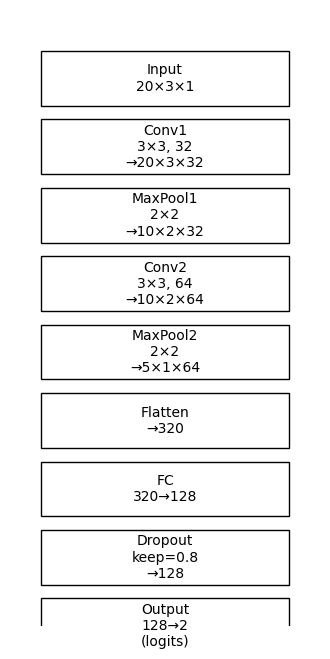

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(4, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 9)

layers = [
    ("Input\n20×3×1", 8),
    ("Conv1\n3×3, 32\n→20×3×32", 7),
    ("MaxPool1\n2×2\n→10×2×32", 6),
    ("Conv2\n3×3, 64\n→10×2×64", 5),
    ("MaxPool2\n2×2\n→5×1×64", 4),
    ("Flatten\n→320", 3),
    ("FC\n320→128", 2),
    ("Dropout\nkeep=0.8\n→128", 1),
    ("Output\n128→2\n(logits)", 0)
]

for text, y in layers:
    rect = patches.Rectangle((0.1, y - 0.4), 0.8, 0.8, fill=False)
    ax.add_patch(rect)
    ax.text(0.5, y, text, ha='center', va='center')

ax.axis('off')
plt.show()
